Collecting workspace information

This notebook processes a point cloud dataset and generates a 3D mesh from it.
Here is a step-by-step summary of what the notebook does:

1. **Imports and Initial Setup**:
   - Imports necessary libraries such as 
   - Loads the point cloud data from a text file (`FBH 1 - Cloud Points - only
     points.txt`).

2. **Data Visualization**:
   - Plots histograms of the point cloud data along the x, y, and z axes to
     understand the distribution of points.
   - Creates a scatter plot of the point cloud data with color coding based on
     one of the coordinates.

3. **2D Histogram and Surface Creation**:
   - Defines the horizontal and vertical axes for binning the point cloud data.
   - Creates a 2D histogram to bin the point cloud data along the specified
     axes.
   - Stores the maximum z value for each bin to create a surface representation
     of the point cloud.

4. **Interpolation**:
   - Uses `scipy.interpolate.NearestNDInterpolator` to fill in any missing
     values (NaNs) in the surface representation.
   - Plots the interpolated surface to visualize the filled-in data.

5. **Conversion to Xarray DataArray**:
   - Converts the units from millimeters to meters.
   - Creates an `xarray.DataArray` to store the surface data with appropriate
     coordinates and attributes.
   - Plots the `DataArray` to visualize the surface.

6. **Postprocessing**:
   - Adjusts the surface data to fit nicely into the domain by removing the
     minimum.
   - Plots the adjusted surface data.

7. **Layered Model Creation**:
   - Creates a layered model using the `salvus` library, defining the surface
     and material properties (density and velocity).

8. **Mesh Generation**:
   - Defines the domain for the mesh based on the extent of the
     `xarray.DataArray`.
   - Sets the mesh resolution based on a reference frequency.
   - Generates the mesh using the `salvus` library and writes it to an HDF5
     file.

You will likely need to postprocess the data to fit your use case.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from scipy.interpolate import NearestNDInterpolator

import salvus.namespace as sn

--> Server: 'https://l.mondaic.com/licensing_server', User: 'bristol.support', Group: 'UniversityOfBristol'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.47 seconds]


In [2]:
point_cloud = np.loadtxt(
    "./FBH 1 - Cloud Points - only points.txt", skiprows=3, delimiter=";"
)

In [3]:
point_cloud.shape

(319540, 3)

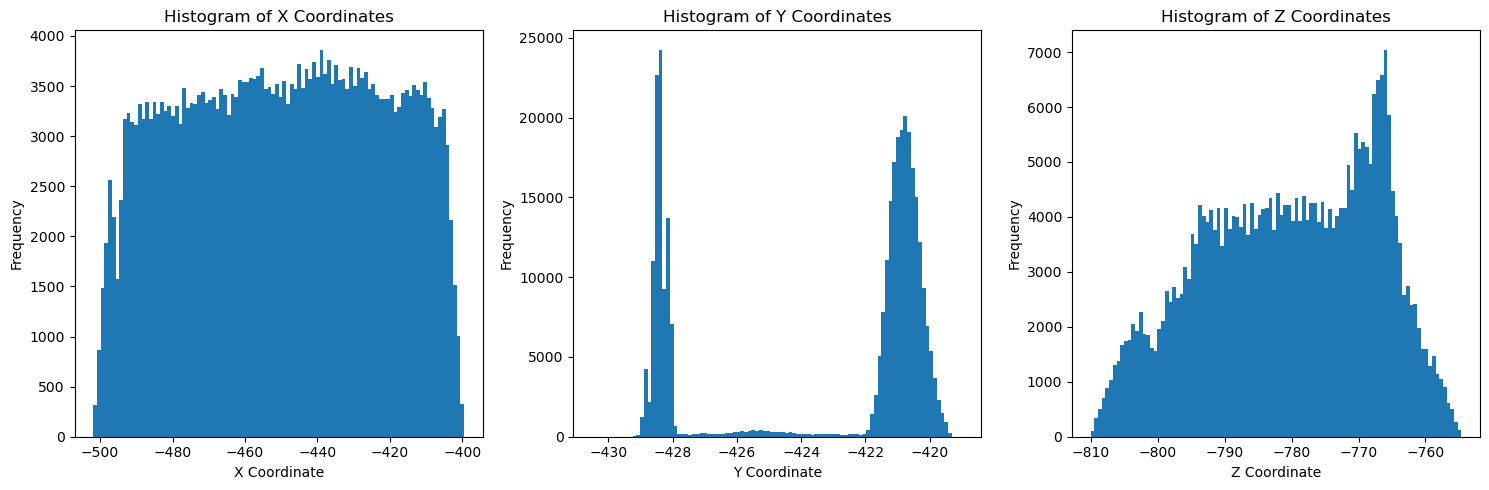

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histogram for X coordinates
axs[0].hist(point_cloud[..., 0], bins=100)
axs[0].set_title("Histogram of X Coordinates")
axs[0].set_xlabel("X Coordinate")
axs[0].set_ylabel("Frequency")

# Plot histogram for Y coordinates
axs[1].hist(point_cloud[..., 1], bins=100)
axs[1].set_title("Histogram of Y Coordinates")
axs[1].set_xlabel("Y Coordinate")
axs[1].set_ylabel("Frequency")

# Plot histogram for Z coordinates
axs[2].hist(point_cloud[..., 2], bins=100)
axs[2].set_title("Histogram of Z Coordinates")
axs[2].set_xlabel("Z Coordinate")
axs[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

We will interpret the **SECOND COORDINATE AS THE ELEVATION**.

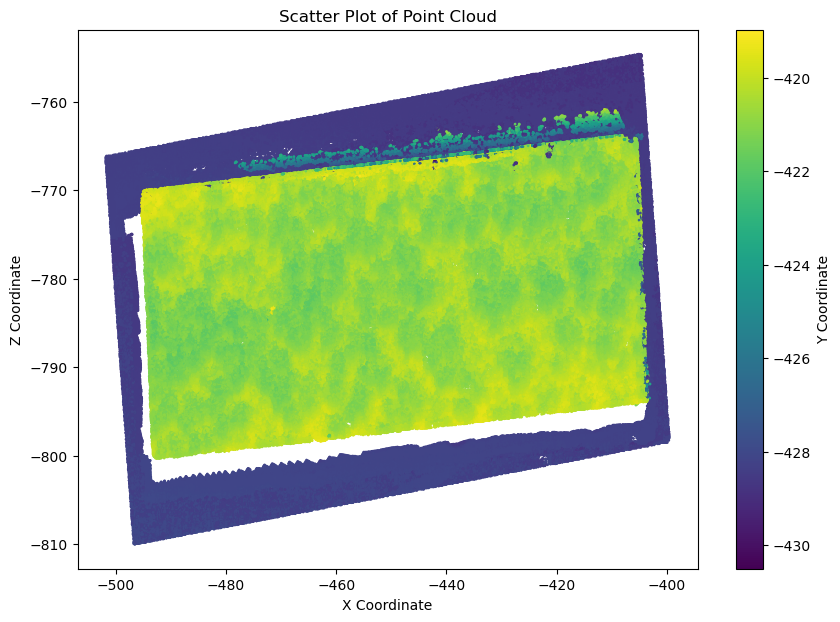

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(
    point_cloud[..., 0],
    point_cloud[..., 2],
    c=point_cloud[..., 1],
    s=1,
    cmap="viridis",
)
ax.set_title("Scatter Plot of Point Cloud")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Z Coordinate")
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Y Coordinate")
plt.show()

Creating a surface from point cloud data often involves several steps, one of which can be binning the data into a 2D histogram and storing the maximum z value for each bin. Here's why this is useful:

1. Data Reduction: Point cloud data can be very dense and contain millions of points. Binning the data reduces the number of points by grouping them into bins, making the data more manageable.

2. Surface Representation: By storing the maximum z value for each bin, you effectively create a height map. This height map can be used to represent the surface of the object. Each bin corresponds to a small area on the xy-plane, and the maximum z value represents the height of the surface at that area.

3. Consistent Surface: By using the maximum z value, you create a consistent and continuous surface. This is particularly important in applications like terrain modeling, where the surface should represent the highest elevation at any given point to avoid undercuts or overhangs that are not physically accurate. **Salvus' layered mesher can't handle overhangs and undercuts**.



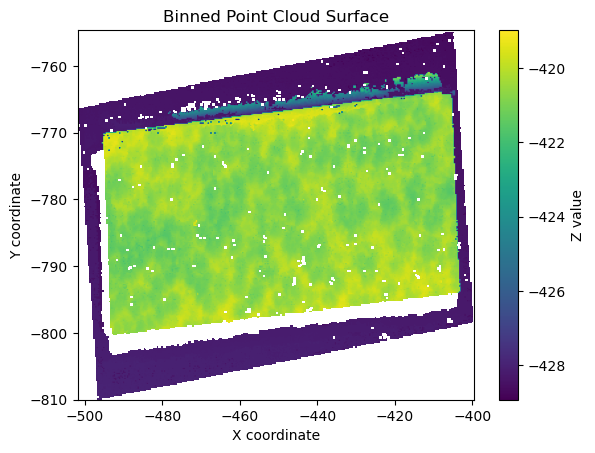

In [6]:
horizontal_1 = 0
horizontal_2 = 2
vertical = 1

bin_count = 300

# Create a 2D histogram with bins for the horizontal coordinates
x_bins = np.linspace(
    point_cloud[:, horizontal_1].min(),
    point_cloud[:, horizontal_1].max(),
    bin_count,
)
y_bins = np.linspace(
    point_cloud[:, horizontal_2].min(),
    point_cloud[:, horizontal_2].max(),
    bin_count,
)

# Use np.digitize to find the bin index for each point
x_indices = np.digitize(point_cloud[:, horizontal_1], x_bins)
y_indices = np.digitize(point_cloud[:, horizontal_2], y_bins)

# Create an array to store the maximum z value for each bin
z_surface = np.full((len(x_bins), len(y_bins)), -np.inf)

# Iterate over the points and update the z_surface array
for i in range(point_cloud.shape[0]):
    x_idx = x_indices[i] - 1
    y_idx = y_indices[i] - 1
    z_value = point_cloud[i, vertical]
    # Grab only the highest z value for each bin
    if z_value > z_surface[x_idx, y_idx]:
        z_surface[x_idx, y_idx] = z_value

# Replace -inf with NaN for better visualization
z_surface[z_surface == -np.inf] = np.nan

# Plot the surface
plt.imshow(
    z_surface.T,
    origin="lower",
    extent=(x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()),
    aspect="auto",
)
plt.colorbar(label="Z value")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Binned Point Cloud Surface")
plt.show()

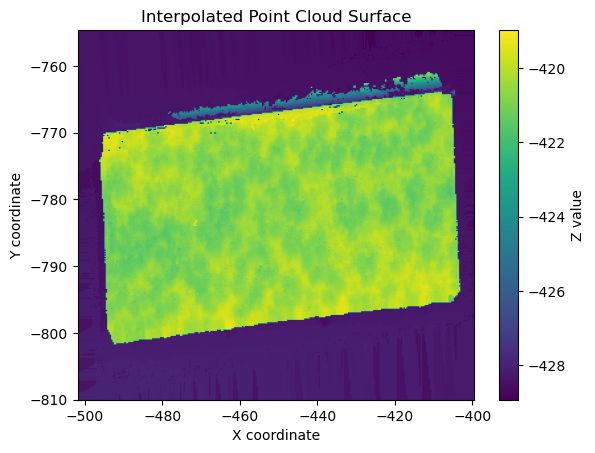

In [7]:
# Get the coordinates of the non-NaN values
x_coords, y_coords = np.meshgrid(x_bins, y_bins, indexing="ij")
valid_mask = ~np.isnan(z_surface)
valid_x = x_coords[valid_mask]
valid_y = y_coords[valid_mask]
valid_z = z_surface[valid_mask]

# Create the interpolator
interpolator = NearestNDInterpolator(list(zip(valid_x, valid_y)), valid_z)

# Interpolate the NaN values
nan_mask = np.isnan(z_surface)
z_surface[nan_mask] = interpolator(x_coords[nan_mask], y_coords[nan_mask])

# Plot the interpolated surface
plt.imshow(
    z_surface.T,
    origin="lower",
    extent=(x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()),
    aspect="auto",
)
plt.colorbar(label="Z value")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Interpolated Point Cloud Surface")
plt.show()

Convert to a dataarray in meters (what salvus requires).

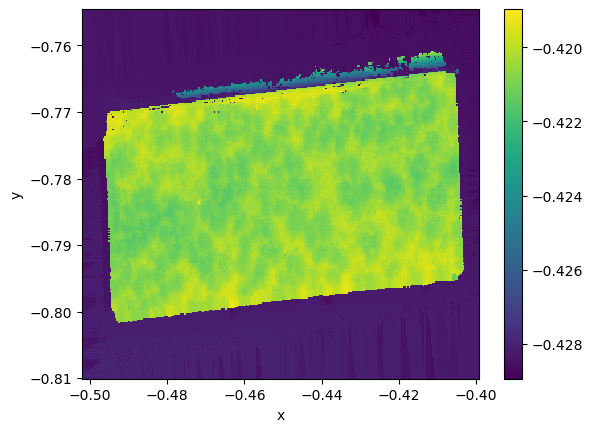

In [8]:
# Convert units from mm to meters
z_surface_meters = z_surface / 1000
x_bins_meters = x_bins / 1000
y_bins_meters = y_bins / 1000

# Create the DataArray
z_surface_da = xr.DataArray(
    z_surface_meters,
    coords={"x": x_bins_meters, "y": y_bins_meters},
    dims=["x", "y"],
    attrs={"reference_elevation": 0.0},
)

# Print the DataArray
z_surface_da.T.plot()

You'll likely want to postprocess this such that all the extraneous elevation isn't included, and that the actual elevation model is rectangular.

All the processing below is just me trying different stuff to remove artefacts in the mesh.

Also, let's simply remove the minimum coordinate value, s.t. this is easier to work with.

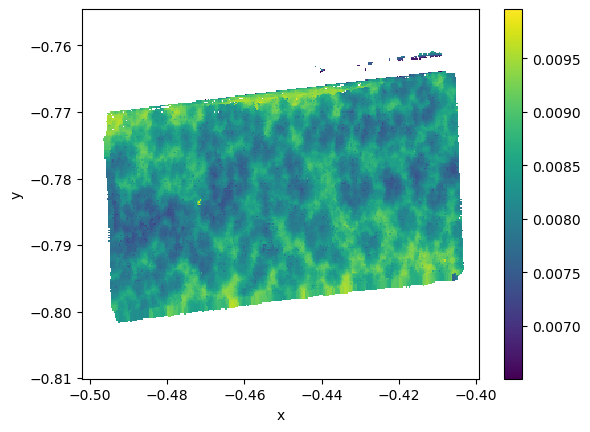

In [9]:
new_height = z_surface_da - z_surface_da.min()

clip_value = 0.0065
new_height_clipped = xr.where(new_height >= 0.0065, new_height, np.nan)

new_height_clipped.T.plot()

I had a lot of trouble with tiny speckles of 1 wrong value deforming elements strongly, this was my fix:

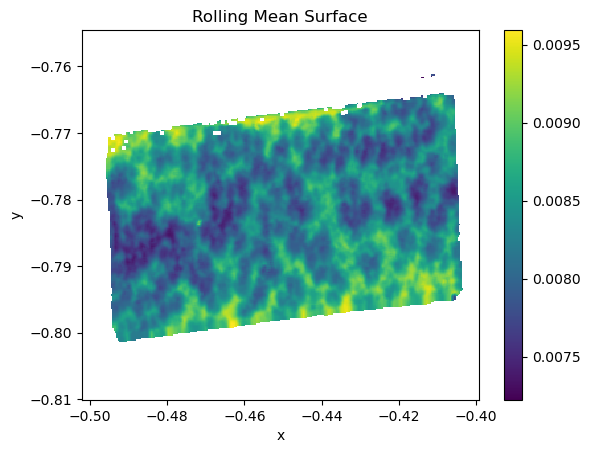

In [10]:
# Apply rolling mean with a window size of 3 in both x and y dimensions
rolling_mean = new_height_clipped.rolling(x=3, y=3, center=True).mean()

# Plot the rolling mean surface
rolling_mean.T.plot()
plt.title("Rolling Mean Surface")
plt.show()

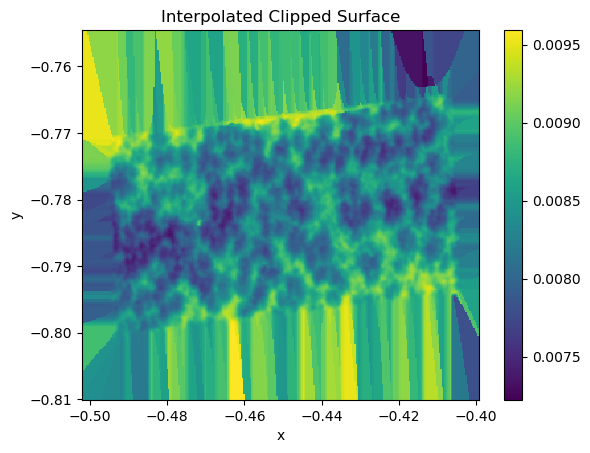

In [11]:
# Get the coordinates of the non-NaN values after clipping
valid_mask_clipped = ~np.isnan(rolling_mean)
valid_x_clipped = x_coords[valid_mask_clipped]
valid_y_clipped = y_coords[valid_mask_clipped]
valid_z_clipped = rolling_mean.values[valid_mask_clipped]

# Create the interpolator for the clipped data
interpolator_clipped = NearestNDInterpolator(
    list(zip(valid_x_clipped, valid_y_clipped)), valid_z_clipped
)

# Interpolate the NaN values in the clipped data
nan_mask_clipped = np.isnan(rolling_mean)
rolling_mean.values[nan_mask_clipped] = interpolator_clipped(
    x_coords[nan_mask_clipped], y_coords[nan_mask_clipped]
)

# Plot the interpolated clipped surface
rolling_mean.T.plot()
plt.title("Interpolated Clipped Surface")
plt.show()

In [12]:
layered_model = sn.layered_meshing.layered_model.LayeredModel(
    [
        sn.layered_meshing.interface.Surface(
            rolling_mean.assign_attrs(
                {
                    # The elevation will be ON TOP of the domain.
                    "reference_elevation": sn.layered_meshing.interface.Depth(
                        0.0
                    )
                }
            )
        ),
        sn.material.acoustic.Velocity.from_params(rho=1500, vp=5000),
    ]
)

In [ ]:
# Define the domain using the extent of the xarray DataArray
domain = sn.domain.dim3.BoxDomain.from_bounds(
    x=(float(z_surface_da.x.min()), float(z_surface_da.x.max())),
    y=(float(z_surface_da.y.min()), float(z_surface_da.y.max())),
    z=(0, 0.02),
)

# 5 MHz seems to work well on a laptop machine. Will create about 300MB of data
# on disk, 10MHz will create about 2.6GB of data.
ref_freq = 5e6
mr = sn.MeshResolution(reference_frequency=ref_freq)

mesh = sn.layered_meshing.mesh_from_domain(
    domain=domain, model=layered_model, mesh_resolution=mr
)

mesh.write_h5(f"mesh_from_point_cloud_{int(ref_freq)}.h5")

In [14]:
mesh